In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import os

import torch as t
import torchvision as tv
from torchvision.transforms import v2
#from torchinfo import summary

from tqdm import tqdm

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/scripts')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Mounted at /content/drive
Using cpu for inference


In [2]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
t.set_grad_enabled(False)
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 135MB/s]


In [3]:
my_inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.CenterCrop(224),
     ])

In [4]:
data_root = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/'
imagenet_val = tv.datasets.ImageNet(data_root, split = 'val', transform = v2.CenterCrop(224))
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)

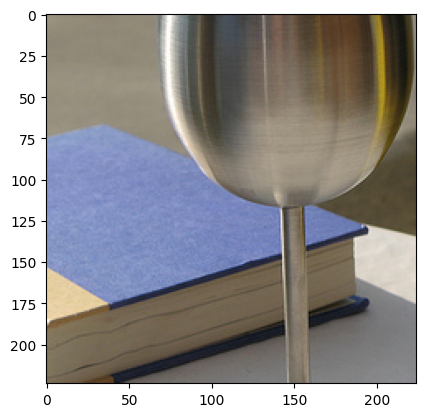

In [ ]:
plt.imshow(imagenet_val[28621][0])
fav_pic_index = 28621

In [ ]:
# "val_images_folder = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/ImageNetValid_256/'
# directory_files = os.listdir(val_images_folder)
# image_raw = []
# image_processed = []
# for i in range(10):
#   image_raw.append((tv.io.read_image(val_images_folder + directory_files[i])))
#   image_processed.append(inference_transform(tv.io.read_image(val_images_folder + directory_files[i])))

# image_raw = t.stack(image_raw, dim = 0)
# image_processed = t.stack(image_processed, dim = 0)

### Distortion

In [5]:
from distortion_utils import dense_transform_amplitude, sparse_transform_amplitude, create_grid_sample, find_inv_grid, jacobian_det, get_version

In [6]:
def get_sparse_grid_sample(amplitudes, num_diffeo, x_cutoff = 10, y_cutoff = 10, num_terms = 3, x_resolution = 224, y_resolution = 224):
  batch_grid_sample = []
  # batch_inverse_grid_sample = []
  for amp in amplitudes:
    A_nm, B_nm = sparse_transform_amplitude(x_cutoff, y_cutoff, num_terms, amplitude = amp, loop = num_diffeo)
    #A_nm = np.mean(A_nm, axis = 0)
    #B_nm = np.mean(B_nm, axis = 0)
    for A, B in zip(A_nm, B_nm):
      grid_sample = create_grid_sample(x_resolution, y_resolution, A, B)
    #inverse_grid_sample, _ = find_inv_grid(grid_sample)
      batch_grid_sample.append(grid_sample)
    #batch_inverse_grid_sample.append(inverse_grid_sample)
  grid_sample = t.cat(batch_grid_sample)
  return grid_sample

In [7]:
amplitudes = t.tensor([0,0.5,1,1.5,2])
grid_sample = get_sparse_grid_sample(amplitudes, 1)
val_image_repeat = imagenet_val_inference[28621][0].unsqueeze(0).repeat(5,1,1,1)
distorted_list = t.nn.functional.grid_sample(val_image_repeat, grid_sample, mode = 'bilinear')

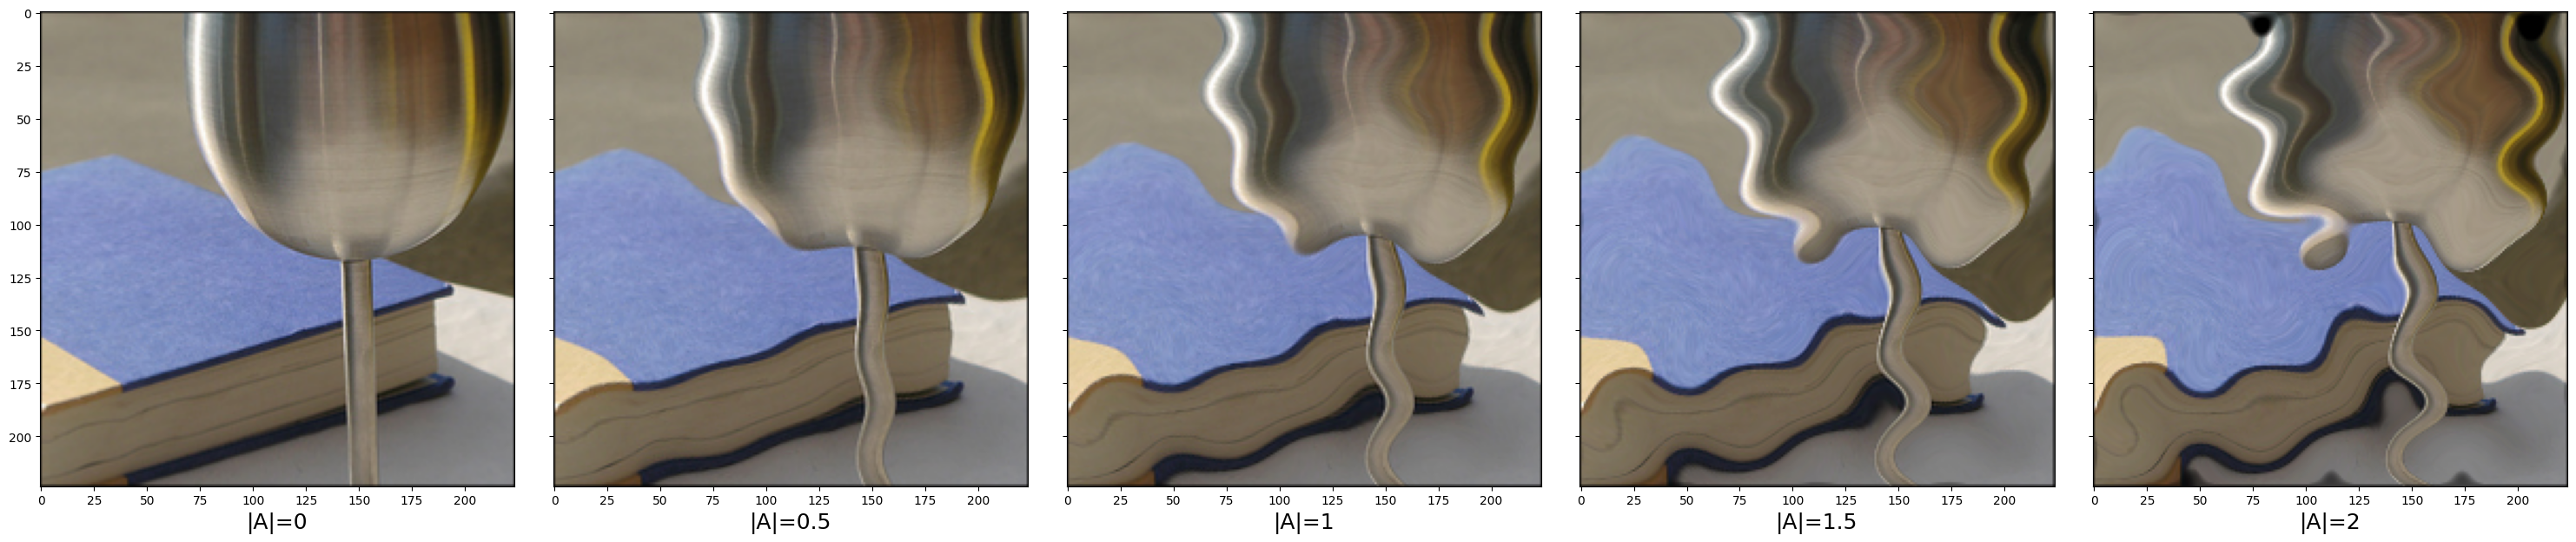

In [14]:
fig, axes = plt.subplots(1,5, figsize = (30,6), sharey=True)
axes[0].imshow(v2.ToPILImage()(distorted_list[0].squeeze()));
axes[0].set_xlabel(r'|A|=0', fontsize=18);
axes[1].imshow(v2.ToPILImage()(distorted_list[1].squeeze()));
axes[1].set_xlabel(r'|A|=0.5', fontsize=18);
axes[2].imshow(v2.ToPILImage()(distorted_list[2].squeeze()));
axes[2].set_xlabel(r'|A|=1', fontsize=18);
axes[3].imshow(v2.ToPILImage()(distorted_list[3].squeeze()));
axes[3].set_xlabel(r'|A|=1.5', fontsize=18);
axes[4].imshow(v2.ToPILImage()(distorted_list[4].squeeze()));
axes[4].set_xlabel(r'|A|=2', fontsize=18);
plt.tight_layout()

In [ ]:
# # A_nm = np.zeros_like(A_nm)
# grid_sample = create_grid_sample(224, 224, A_nm, B_nm)

# grid_sample = create_grid_sample(224, 224, A_nm, B_nm)
# inverse_grid_sample, loss_hist = find_inv_grid(grid_sample)

# distorted = t.nn.functional.grid_sample(imagenet_val_inference[28621][0].unsqueeze(0), grid_sample, mode = 'bilinear')
# undistorted = t.nn.functional.grid_sample(distorted, inverse_grid_sample, mode = 'bicubic')

In [ ]:
# fig, axes = plt.subplots(1,4, figsize = (24,6))
# axes[0].imshow(v2.ToPILImage()(imagenet_val_inference[28621][0]))
# axes[1].imshow(v2.ToPILImage()(distorted.squeeze()))
# axes[2].imshow(v2.ToPILImage()(undistorted.squeeze()))

# # ref_pic = t.nn.functional.grid_sample(val_pic_tensor.unsqueeze(0), t.stack((Y, X), dim=-1).unsqueeze(0), mode = 'bilinear')

# cbar = axes[3].imshow(t.linalg.vector_norm(undistorted.squeeze() - imagenet_val_inference[28621][0].squeeze(), dim = 0))
# cax = fig.add_axes([axes[3].get_position().x1+0.01,axes[3].get_position().y0,0.02,axes[3].get_position().height])
# plt.colorbar(cbar, cax = cax)

In [ ]:
# inv_distorted = t.nn.functional.grid_sample(imagenet_val_inference[28621][0].unsqueeze(0), inverse_grid_sample, mode = 'bilinear')
# inv_inv_distort = t.nn.functional.grid_sample(inv_distorted, grid_sample, mode = 'bilinear')
# plt.imshow(v2.ToPILImage()(inv_inv_distort.squeeze()))

### Check Layers

In [ ]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
handles = []
def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [ ]:
imagenet_val_loader = iter(t.utils.data.DataLoader(imagenet_val_inference, batch_size = 1, shuffle=False))

In [ ]:
amp_steps = 20
diffeo_num = 50
diffeo_amp = t.linspace(0, 1.5, amp_steps)
grid_sample = get_sparse_grid_sample(diffeo_amp, diffeo_num, x_cutoff= 10, y_cutoff = 10, num_terms = 3, x_resolution =224, y_resolution= 224)

In [ ]:
path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/data/'
t.save(grid_sample, path + '20-50-10-10-3-224-224_grid_sample.pt')
for i in tqdm(range(100)):
  file_prefix = f'20-50-10-10-3-224-224_image-{i:04d}_activation'
  val_image, _ = next(imagenet_val_loader)
  distorted_list = t.nn.functional.grid_sample(val_image.repeat(amp_steps * diffeo_num,1,1,1), grid_sample, mode = 'bilinear').to(device)
  retrieve_layer_activation(ENV2, distorted_list, [5,9,13,19,28,36,43,46,49])
  for key in activation.keys():
    t.save(activation[key], path + file_prefix + f'_layer-{int(key):02d}.pt')
  activation = {}
  handle = []

 32%|███▏      | 32/100 [20:08<43:03, 38.00s/it]

In [ ]:
activation[keys]

tensor([[ 7.0575,  2.1519,  0.3932,  ...,  0.2788,  0.0347, -0.1398],
        [ 7.0575,  2.1519,  0.3932,  ...,  0.2788,  0.0347, -0.1398],
        [ 7.0575,  2.1519,  0.3932,  ...,  0.2788,  0.0347, -0.1398],
        ...,
        [ 2.9965,  0.6313,  0.8640,  ...,  1.2983, -0.1927, -1.1453],
        [ 1.9280, -0.0486,  0.4360,  ...,  0.4484, -0.0172, -0.5723],
        [ 2.0305, -0.3391,  1.9686,  ...,  0.6016, -0.5310, -0.8604]],
       device='cuda:0')

In [ ]:
for keys in activation.keys():
  print(keys)

5
9
13
19
28
36
43
46
49


In [ ]:
for keys in activation.keys():
  print(f'key{int(keys):04d}')

key0005
key0009
key0013
key0019
key0028
key0036
key0043
key0046
key0049


In [ ]:
# val_image_repeat = imagenet_val_inference[28621][0].unsqueeze(0).repeat(61,1,1,1)
val_image, _ = next(imagenet_val_loader)
distorted_list = t.nn.functional.grid_sample(val_image.repeat(amp_steps * diffeo_num,1,1,1), grid_sample, mode = 'bilinear').to(device)

In [ ]:
retrieve_layer_activation(ENV2, distorted_list, [5,9,13,19,28,36,43,46,49])
activation.keys()

dict_keys(['5', '9', '13', '19', '28', '36', '43', '46', '49'])

In [ ]:
activation['49']

tensor([[ 7.8953,  1.9427, -1.1995,  ...,  1.3872,  1.8045, -0.7876],
        [ 7.8953,  1.9427, -1.1995,  ...,  1.3872,  1.8045, -0.7876],
        [ 7.8953,  1.9427, -1.1995,  ...,  1.3872,  1.8045, -0.7876],
        ...,
        [ 2.5053,  0.4710,  0.1332,  ...,  0.4299,  0.3177, -0.7318],
        [ 2.6321,  0.0901,  0.0289,  ...,  0.1747,  1.0612, -0.8889],
        [ 4.1233,  0.9348, -0.0871,  ...,  0.1082,  0.0510,  0.4101]],
       device='cuda:0')

In [ ]:
old_activation['49']

tensor([[ 8.4127,  1.7439, -0.4420,  ...,  0.7989,  0.5134, -0.4124],
        [ 8.4127,  1.7439, -0.4420,  ...,  0.7989,  0.5134, -0.4124],
        [ 8.4127,  1.7439, -0.4420,  ...,  0.7989,  0.5134, -0.4124],
        ...,
        [ 0.5999,  0.2402, -0.3854,  ...,  0.3958,  0.1868, -0.5491],
        [ 0.9172,  0.7484,  0.1089,  ...,  0.3326,  0.4089, -0.3254],
        [ 2.6926,  2.0269,  0.1047,  ...,  2.5348,  0.2683,  0.9051]],
       device='cuda:0')

In [ ]:
final_layer_normalized = t.nn.functional.normalize(activation['49'])
final_layer_outer = t.einsum('ik,jk -> ij', final_layer_normalized, final_layer_normalized)

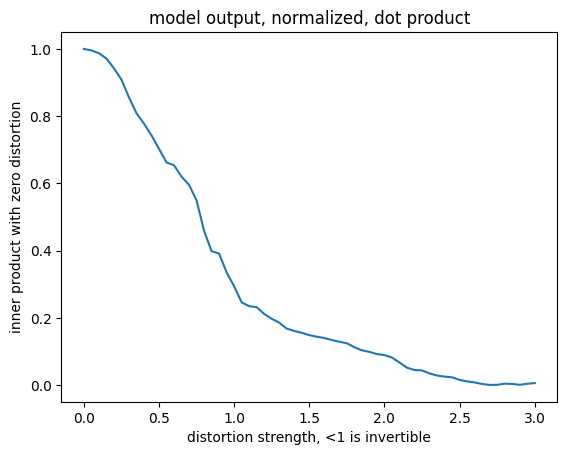

In [ ]:
plt.plot(np.arange(61)/20, final_layer_outer[0])
plt.xlabel('distortion strength, <1 is invertible');
plt.ylabel('inner product with zero distortion');
plt.title('model output, normalized, dot product');

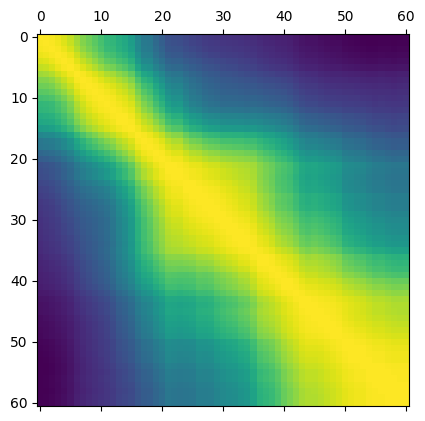

In [ ]:
plt.matshow(final_layer_outer)

In [ ]:
final_layer_normalized

torch.Size([61, 61])

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider

In [ ]:
def plot_matrix(matrix_index):
    plt.imshow(activation['46'][3][matrix_index], cmap='viridis')
    plt.title(f"Matrix {matrix_index}")
    plt.colorbar()
    plt.show()

# Determine the range of the slider based on the length of the matrix list
matrix_range = len(activation['46'][3]) - 1

# Create an interactive slider
interact(plot_matrix, matrix_index=IntSlider(min=0, max=matrix_range, step=1, value=0))

interactive(children=(IntSlider(value=0, description='matrix_index', max=1279), Output()), _dom_classes=('widg…

<function __main__.plot_matrix(matrix_index)>

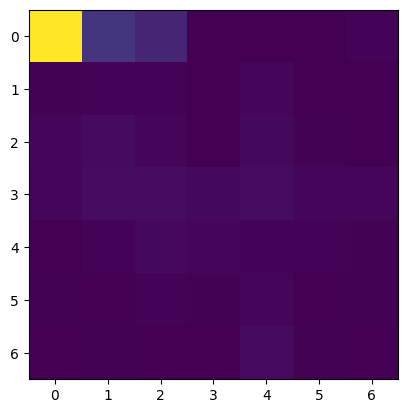

In [ ]:
plt.imshow(activation['46'][0][100])